In [1]:
import os
import math
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
path = "/Users/jorgerag/Documents/UCSD/courses/Winter23/COGS181/final_project/"
os.chdir(path)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
def get_source(df):
    res = []
    for i in range(0, len(df)):
        res.append(np.array(df["gcamp_lp"].iloc[i], dtype="float32"))
    res = np.array(res)
    return torch.from_numpy(res[1:])

In [3]:
class PositionalEncoding(
    nn.Module,
):
    # needs to go at the bottom of the encoder and decoder stacks
    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 3000):
        super().__init__()

        # Hyperparameter: to introduce regularization that prevents against overfitting
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        pe = torch.squeeze(pe)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :].requires_grad_(False)
        return self.dropout(x)

In [45]:
class Transformer(nn.Module):

    # input var
    def __init__(
        self,
        num_input_variables,
        dim_val,
        encoder_dim_feedforward_d_model_scalar,
        encoder_dropout,
        encoder_num_layers,
        encoder_activation,
        encoder_num_heads,
        decoder_dim_feedforward_d_model_scalar,
        decoder_dropout,
        decoder_num_layers,
        decoder_num_heads,
        decoder_activation,
        max_seq,
        num_classes, 
        embedding_size
    ):
        
        super().__init__()
        self.encoder_input_layer = nn.Linear(in_features=max_seq, out_features=dim_val)
        self.positional_encoding = PositionalEncoding(dim_val, max_len=max_seq)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val,
            nhead=encoder_num_heads,
            dim_feedforward=dim_val * encoder_dim_feedforward_d_model_scalar,
            dropout=encoder_dropout,
            activation=encoder_activation)
        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=encoder_num_layers)
        self.decoder_input_layer = nn.Linear(in_features=num_input_variables, out_features=dim_val)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=decoder_num_heads,
            dim_feedforward=dim_val * decoder_dim_feedforward_d_model_scalar,
            dropout=decoder_dropout,
            activation=decoder_activation)
        self.decoder = nn.TransformerDecoder(decoder_layer=decoder_layer, num_layers=decoder_num_layers)
        self.out = nn.Linear(in_features=dim_val, out_features=num_classes)

    def forward(self, source, target):
        source = self.encoder_input_layer(source)
        source = self.positional_encoding(source)
        source = self.encoder(src=source)
        target = self.decoder_input_layer(target)
        target = self.decoder(tgt=target, memory=source)
        target = self.out(target)
        return target

In [46]:
trainingset = pd.DataFrame(pd.read_json("data/processed/train_data.json"))
testset = pd.DataFrame(pd.read_json("data/processed/test_data.json"))
# drop infs
trainingset = trainingset[~trainingset.isin([np.nan, np.inf, -np.inf]).any(1)]
testset = testset[~testset.isin([np.nan, np.inf, -np.inf]).any(1)]

# Get valdiation split
unique_obj = trainingset.groupby(["subject", "threshold", "day"]).size().reset_index()
unique_obj = unique_obj.to_dict('records')
unique_obj_df = pd.DataFrame(unique_obj)[['subject', 'day']]
# Split to train and validation
## Take one trial per subject as validation choosing randonmly from each of the subjects with more than one day.
validation_trials = unique_obj_df[~unique_obj_df["subject"].isin([3203, 3315])].groupby('subject').apply(lambda x: x.sample(n = 1, random_state = 123)).reset_index(drop=True)
keys = list(validation_trials.columns.values)
i1 = trainingset.set_index(keys).index
i2 = validation_trials.set_index(keys).index

train_df = trainingset[~i1.isin(i2)]
validation_df = trainingset[i1.isin(i2)]

## Divide datasets by trials
gb = train_df.groupby(["subject", "day"])
trials = [gb.get_group(x) for x in gb.groups]

gb_val = validation_df.groupby(["subject", "day"])
val_trials = [gb_val.get_group(x) for x in gb_val.groups]

gb_test = testset.groupby(["subject", "day"])
test_trials = [gb_test.get_group(x) for x in gb_test.groups]

/var/folders/mj/fbzmtcxx50g7hksjvdvr0kh00000gn/T/ipykernel_61325/3167382495.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  trainingset = trainingset[~trainingset.isin([np.nan, np.inf, -np.inf]).any(1)]
/var/folders/mj/fbzmtcxx50g7hksjvdvr0kh00000gn/T/ipykernel_61325/3167382495.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  testset = testset[~testset.isin([np.nan, np.inf, -np.inf]).any(1)]


In [69]:
dim_val = 100
n_heads = 10
n_decoder_layers = 4
n_encoder_layers = 4
max_seq = 703
embedding_size = 10
num_classes = 1

epochs = 100
lr = 0.0001
momentum = 0.5
loss_function = nn.MSELoss()

model = Transformer(
    num_input_variables=1,
    dim_val=dim_val,
    encoder_dim_feedforward_d_model_scalar=5,
    encoder_dropout=0.5,
    encoder_num_layers=n_encoder_layers,
    encoder_activation="relu",
    encoder_num_heads=n_heads,
    decoder_dim_feedforward_d_model_scalar=5,
    decoder_dropout=0.5,
    decoder_num_layers=n_decoder_layers,
    decoder_num_heads=n_heads,
    decoder_activation="relu",
    max_seq=max_seq,
    num_classes=num_classes,
    embedding_size=embedding_size
)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [70]:
all_losses = []
for epoch in range(epochs):
    train_loss = 0
    target_list = []
    predicted_total = []
    model.train()
    for trial in trials:
        optimizer.zero_grad()
        source = get_source(trial)
        # Padding source to max lenght of sequence
        source = F.pad(source, pad=(0, 0, 0, max_seq + 1 - len(trial)), mode="constant", value=0).T
        residual = source
        target = torch.tensor(trial["lp_duration"][1:].values).to(torch.int64)
        target = target.unsqueeze(1).type(torch.FloatTensor)
        target_list = target_list + torch.squeeze(target).tolist()
        predicted_lp = model(source=source, target=target)
        loss = loss_function(predicted_lp, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predicted_total = predicted_total + torch.squeeze(predicted_lp).tolist()[:len(trial)]
    all_losses.append(train_loss / len(trials))
    print("-------------------------------------")
    print("Average Training Loss:", train_loss / len(trials))


-------------------------------------
Average Training Loss: 5993991.25
-------------------------------------
Average Training Loss: 5593790.180921053
-------------------------------------
Average Training Loss: 5431593.0855263155
-------------------------------------
Average Training Loss: 5416732.935855263
-------------------------------------
Average Training Loss: 5405271.6019736845
-------------------------------------
Average Training Loss: 5403674.58881579
-------------------------------------
Average Training Loss: 5400561.988486842
-------------------------------------
Average Training Loss: 5395217.856907895
-------------------------------------
Average Training Loss: 5396352.080592105
-------------------------------------
Average Training Loss: 5395422.921052632
-------------------------------------
Average Training Loss: 5395233.287828947
-------------------------------------
Average Training Loss: 5393238.544407895
-------------------------------------
Average Training Los

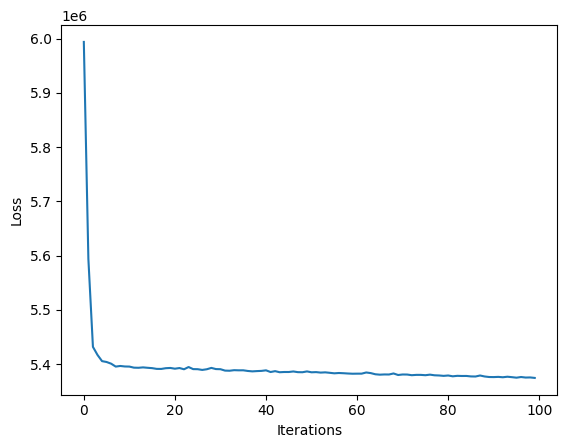

In [71]:
# Training Curve
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot([loss for loss in all_losses])
plt.show()

In [72]:
# Plot predicted vs actual for a test case
source_test = get_source(test_trials[0])
source_test = F.pad(source_test, pad=(0, 0, 0, max_seq + 1 - len(test_trials[0])), mode="constant", value=0).T
target_test = torch.tensor(test_trials[0]["lp_duration"][1:].values)
target_test = target_test.unsqueeze(1).type(torch.FloatTensor)
with torch.no_grad():
    predicted_test = model(source=source_test, target=target_test)

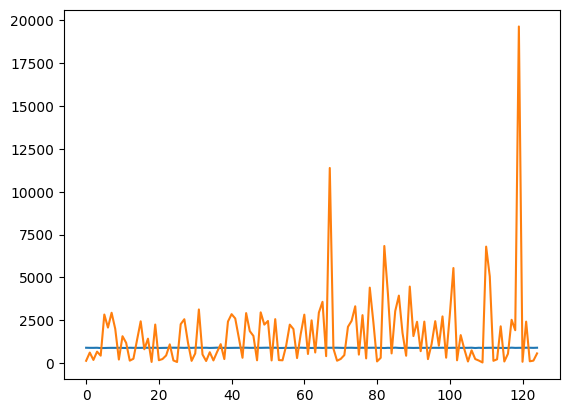

In [74]:
plt.plot(predicted_test.tolist())
plt.plot(target_test.tolist())
plt.show()